Análise do dia 24/03 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import CountVectorizer

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Preparação dos dados

In [2]:
# import dos dados

df = pd.read_csv('2403_preprocessado.csv')

In [3]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [4]:
# aplica função em todos os tokens

df['token3'] = df['token3'].apply(lambda x: strip_characters(x))
df['token3'] = df['token3'].apply(lambda x: str(x).split(' '))

In [5]:
texto = list(df.token3)

# Modelagem

In [6]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [7]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [8]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [9]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [09:26<00:00, 40.45s/it]


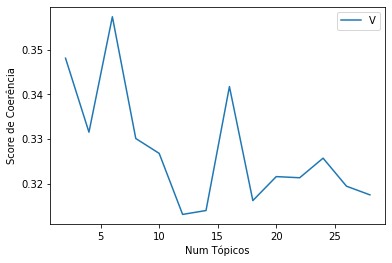

In [10]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [11]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3481
A quantidade de tópicos = 4  tem um valor de coerência de  0.3315
A quantidade de tópicos = 6  tem um valor de coerência de  0.3573
A quantidade de tópicos = 8  tem um valor de coerência de  0.3301
A quantidade de tópicos = 10  tem um valor de coerência de  0.3268
A quantidade de tópicos = 12  tem um valor de coerência de  0.3132
A quantidade de tópicos = 14  tem um valor de coerência de  0.314
A quantidade de tópicos = 16  tem um valor de coerência de  0.3417
A quantidade de tópicos = 18  tem um valor de coerência de  0.3163
A quantidade de tópicos = 20  tem um valor de coerência de  0.3216
A quantidade de tópicos = 22  tem um valor de coerência de  0.3214
A quantidade de tópicos = 24  tem um valor de coerência de  0.3257
A quantidade de tópicos = 26  tem um valor de coerência de  0.3195
A quantidade de tópicos = 28  tem um valor de coerência de  0.3175


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [12]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=3, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        eta = 0.3)

In [13]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -6.487251262934781


In [14]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=texto, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.39213988208955675


In [15]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.381194  0.011642       1        1  36.309410
2      0.180114 -0.323313       2        1  32.202263
1      0.201080  0.311671       3        1  31.488329, topic_info=           Term          Freq         Total Category  logprob  loglift
30   presidente  24010.000000  24010.000000  Default  30.0000  30.0000
212              20421.000000  20421.000000  Default  29.0000  29.0000
1     bolsonaro  28004.000000  28004.000000  Default  28.0000  28.0000
74        gente  10855.000000  10855.000000  Default  27.0000  27.0000
46        agora   7981.000000   7981.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
545      daniel   1040.887817   1041.830200   Topic3  -5.1957   1.1546
66        risco    967.999878    968.884644   Topic3  -5.2683   1.1546
403    parabens    976.850098    977.790649   Topic3  -5.2592   1.1546
221       saber   1019.515991   1020.499573   Topic3  -5.2164   1.1546
1     bolsonaro  24751.281250  28004.908203   Topic3  -2.0269   1.0321

[123 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
212       2  0.999988         
177       1  0.999704   acabar
177       2  0.000245   acabar
46        2  0.999924    agora
39        2  0.000359   alguem
...     ...       ...      ...
68        2  0.000640     vida
107       1  0.998463   voltar
107       2  0.001060   voltar
143       2  0.000663  vontade
143       3  0.999201  vontade

[157 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [16]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [17]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=4, step=2)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.41s/it]


In [18]:
# Escolhe o model

optimal_model = model_list[0]
optimal_model.print_topics(num_topics = 3, num_words = 20)

[(0,
  '0.055*"bolsonaro" + 0.045*"" + 0.019*"casa" + 0.018*"alguem" + 0.012*"corrente" + 0.011*"passar" + 0.011*"gente" + 0.010*"deus" + 0.009*"mae" + 0.009*"filho" + 0.008*"depois" + 0.008*"presidente" + 0.007*"nunca" + 0.006*"vida" + 0.006*"amor" + 0.006*"pandemia" + 0.006*"tava" + 0.006*"voltar" + 0.005*"sair" + 0.005*"possivel"'),
 (1,
  '0.160*"bolsonaro" + 0.038*"pronunciamento" + 0.035*"presidente" + 0.029*"merda" + 0.026*"gente" + 0.018*"cu" + 0.016*"deus" + 0.015*"tomar" + 0.012*"nacional" + 0.011*"tv" + 0.011*"rede" + 0.010*"mundo" + 0.010*"depois" + 0.009*"atleta" + 0.009*"falar" + 0.008*"vez" + 0.007*"caralho" + 0.007*"contra" + 0.007*"pandemia" + 0.007*"boca"'),
 (2,
  '0.083*"presidente" + 0.018*"quando" + 0.015*"brasil" + 0.015*"acabar" + 0.013*"muito" + 0.012*"nem" + 0.012*"bolsonaro" + 0.012*"agora" + 0.011*"pandemia" + 0.008*"vergonha" + 0.008*"sim" + 0.008*"deus" + 0.008*"coisa" + 0.007*"merda" + 0.007*"casa" + 0.007*"nada" + 0.007*"povo" + 0.006*"falar" + 0.006*"sa

In [19]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texto):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [20]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texto)

In [21]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9542,"bolsonaro, , casa, alguem, corrente, passar, g...","[pijama, paz, contatinhos, violento, passo, ge..."
1,1.0,0.9600,"bolsonaro, pronunciamento, presidente, merda, ...","[rede, nacional, crise, pandemia, perdido, cad..."
2,2.0,0.9576,"presidente, quando, brasil, acabar, muito, nem...","[falar, usar, casa, ir, lavar, maos, mal, volt..."


In [23]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,2.0,"presidente, quando, brasil, acabar, muito, nem...",32769.0,0.2448
1.0,1.0,"bolsonaro, pronunciamento, presidente, merda, ...",57765.0,0.4315
2.0,0.0,"bolsonaro, , casa, alguem, corrente, passar, g...",43332.0,0.3237
3.0,1.0,"bolsonaro, pronunciamento, presidente, merda, ...",NaN,NaN
4.0,2.0,"presidente, quando, brasil, acabar, muito, nem...",NaN,NaN
...,...,...,...,...
133861.0,0.0,"bolsonaro, , casa, alguem, corrente, passar, g...",NaN,NaN
133862.0,2.0,"presidente, quando, brasil, acabar, muito, nem...",NaN,NaN
133863.0,2.0,"presidente, quando, brasil, acabar, muito, nem...",NaN,NaN
133864.0,2.0,"presidente, quando, brasil, acabar, muito, nem...",NaN,NaN


In [24]:
# Criando stopwords em português utilizando a biblioteca nltk
import pt_core_news_sm
nlp = pt_core_news_sm.load()
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior',
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'tem', 'as', 'mas','ao'
                    'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkk','kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'obg',
                    'corona','virus','coronavirus','covid','covid19','19'
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda',
                    'vir', 'bem','ao','sem','ou','vai', 'dizer', 'entao', 'dizer', 'entao',
                    'tao', 'tu', 'mim', 'mano', 'oq', 'pos', 'dm', 'dps',
                    'coronavirusoutbreak', 'coronavirusPandemic', 'dar', 'vairus',
                    'ainda', 'assim']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

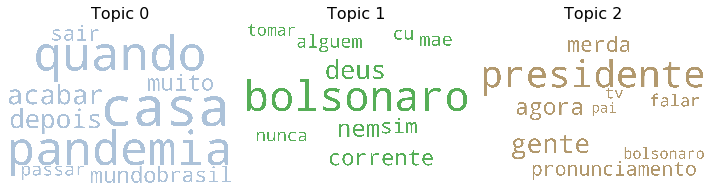

In [25]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=600)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [26]:
sent_topics_sorteddf_mallet.to_excel('keywords_0324.xlsx')